# 1) Get stock data, trim the data.

In [91]:
# Imports
import numpy as np
import ticker_class as tc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

################################################################################

# Instantiate a member of the TickerClass with the ticker you want
spy = tc.TickerClass("SPY")

# Flags
verbose = False    # Parameter to print stuff; not currently implemented
scale = False      # Parameter to scale features

########################################
# FIXME: 
# add start and end as class members?
########################################

# Retrieve data from start to end
start = "1993-01-29"
end   = "2023-10-17"
spy.getData(start,end)

# Trim the data to get rid of excess variables; we're only interested in
# multivariate forecasting with open, high, low and close. This will be the
# basis for our training dataframe.
trimmed_df = spy.stock_data[['Open', 'High', 'Low', 'Close']]

##########################################################
# FIXME:
# Consider using this? 
##########################################################
# Scaling Stuff
if scale:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler = scaler.fit(trimmed_df)
    trimmed_df_array = scaler.transform(trimmed_df)
else:
    # Scaling converts our dataframe into an array; we'll need to replicate this
    # and pop the date index for our matrix generation code to work. 
    trimmed_df_array = trimmed_df.to_numpy()

[*********************100%%**********************]  1 of 1 completed


# 2) Prepare the data for training.

In [92]:
#Empty lists to be populated using formatted training data
x_train = []
y_train = []

# [DONE]
n_future = 1  # Number of days we want to look into the future based on the past days. 
              # 1 is good here; keep 1
n_past = 60   # Number of past days we want to use to predict the future. 
              # 60 is good here

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(trimmed_df_array) - n_future +1):
    x_train.append(trimmed_df_array[i - n_past:i, 0:trimmed_df_array.shape[1]])
    y_train.append(trimmed_df_array[i + n_future - 1:i + n_future, 0])

# The 0th index of x and y train are the total number of days from trimmed_df, 
# minus the amount of days we're using to predict the future. 
x_train, y_train = np.array(x_train), np.array(y_train)

# Save the dates we used to train to plot later
train_dates = trimmed_df.index[0:x_train.shape[0]]

if verbose:
    print('x_train shape == {}.'.format(x_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))

# 3) Build the model

In [93]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# [TUNE THESE]
# Build an LSTM Model
model = Sequential([layers.Input((x_train.shape[1], x_train.shape[2])),
                    layers.LSTM(64, return_sequences=True),
                    # layers.LSTM(64, return_sequences=True),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(32),
                    layers.Dense(64, activation='relu'),
                    # layers.Dense(64, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# [TUNE THESE]
# Compile and summarize the model.
model.compile(loss = 'mse', 
              optimizer = Adam(learning_rate=0.001), # 0.001 is like, perfect?
              metrics = ['mean_absolute_error'])
model.summary()

# [TUNE THESE]
# Fit the model
history = model.fit(x_train, 
                    y_train, 
                    epochs=25,
                    validation_split=0.007, # 0.007 works well
                    verbose=1)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 64)            17664     
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dense_47 (Dense)            (None, 64)                2112      
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 34305 (134.00 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
239/

# 4) Visualize the model and its training metrics

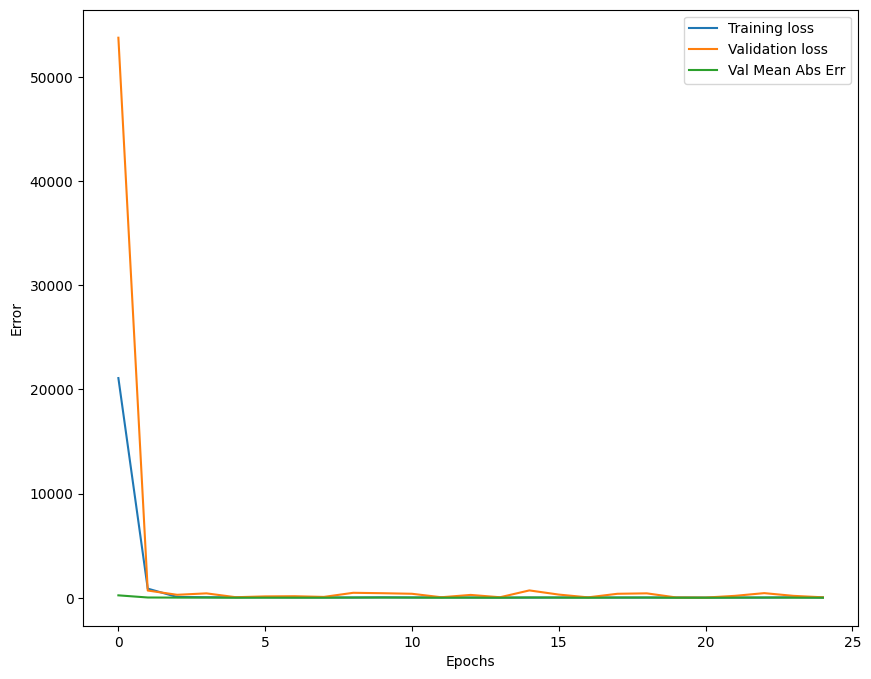

240/240 [==============================] - 3s 10ms/step


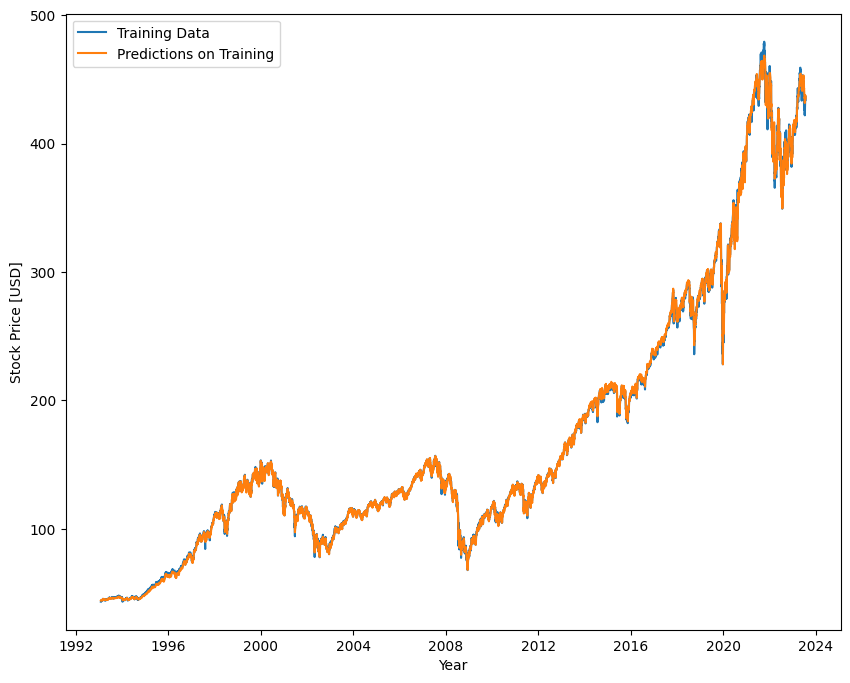

In [94]:
# Visualize training and validation loss
# Set figure dims
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['val_mean_absolute_error'], label='Val Mean Abs Err')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Visualize predictions on training data
# Set figure dims
fig = plt.figure()
fig.set_size_inches(10, 8)
predicitions_on_train = model.predict(x_train).flatten()
plt.plot(train_dates, y_train)
plt.plot(train_dates, predicitions_on_train)
plt.xlabel('Year')
plt.ylabel('Stock Price [USD]')
plt.legend(['Training Data', 'Predictions on Training'])
plt.show()

# 5) Start forecasting

In [95]:
#FIXME
# This entire section is kinda jank

# Imports
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import pandas as pd
import datetime as dt

# Set business days in US
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Helper function to convert strings to datetime
def str2dt(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year, month=month, day=day)

# Helper function to go the other way around
def dt2str(dt):
    return dt.strftime('%Y-%m-%d')
    
# FIXME
# Define the number of days we wish to forecast into the future.
n_forecast_pred = 23
forecast_dates = pd.date_range(start = str2dt(end),
                               periods = n_forecast_pred, 
                               freq=us_bd).to_list()

# Forecast
forecast = model.predict(x_train[-n_forecast_pred:])

# Retrieve true data
spy_verif = tc.TickerClass("SPY")
verif_dates = pd.date_range(start = str2dt(end),
                               # +1 because download is non inclusive
                               periods = n_forecast_pred + 1, 
                               freq=us_bd).to_list()

spy_verif.getData(end, verif_dates[-1])

# FIXME
# drop 11-10 because that isn't forecasted and also not in the forecast dates
verif_data = spy_verif.stock_data['Open'].drop(str2dt('2023-11-10'), axis=0)


1/1 [==============================] - 0s 30ms/step
[*********************100%%**********************]  1 of 1 completed


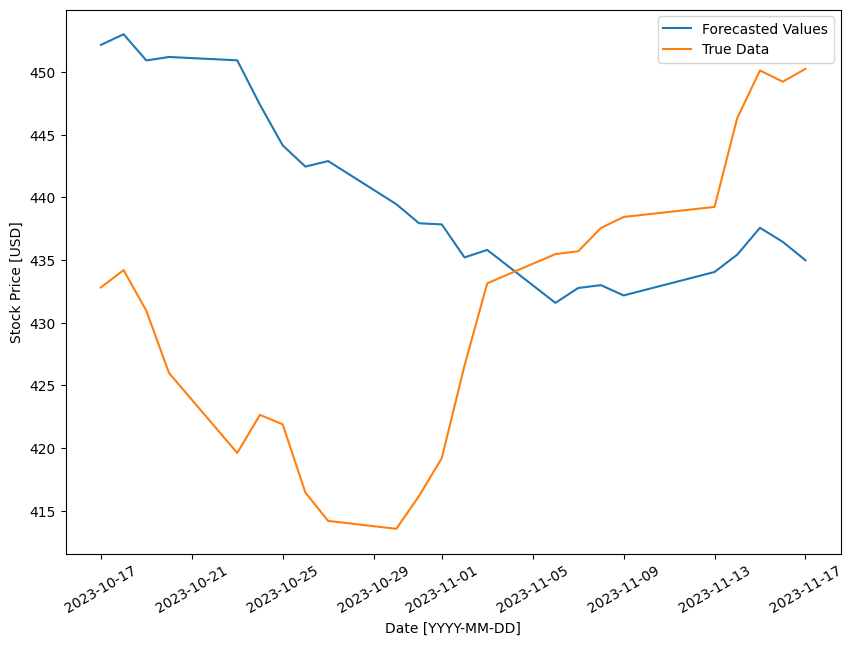

In [96]:
# Set figure dims
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.autofmt_xdate()

# Plot the true data against our forecasted data
plt.plot(forecast_dates, forecast, label='Forecasted Values')
plt.plot(forecast_dates, verif_data, label='True Data')
plt.xticks(rotation=30)
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Stock Price [USD]')
plt.legend()
plt.show()
